In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from selenium import webdriver
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException



In [4]:

MAX_CLICKS = 5
current_click_count = 0
html_content = None
driver = None

    
URL = "https://www.getyourguide.com/london-l57/"
BASE_URL = "https://www.getyourguide.com"
try:
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)

    print(f"Mengakses {URL} menggunakan Selenium...")
    driver.get(URL)

    time.sleep(5) 
    
    SHOW_MORE_XPATH = "//button[.//span[text()='Show more']]"

    while current_click_count < MAX_CLICKS:
        try:
            show_more_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, SHOW_MORE_XPATH))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", show_more_button)
            time.sleep(random.uniform(1, 2))
            
            show_more_button.click()
            current_click_count += 1
            print(f"Klik 'Show more' ke-{current_click_count} berhasil.")
            time.sleep(random.uniform(3, 5))

        except TimeoutException:
            print("Tombol 'Show more' tidak ditemukan lagi.")
            break
        except ElementClickInterceptedException:
            driver.execute_script("window.scrollBy(0, 200);")
            time.sleep(random.uniform(2, 3))
        except Exception as e:
            print(f"Error saat mengklik tombol: {e}")
            break

    print(f"Total klik berhasil: {current_click_count}")
    html_content = driver.page_source
    print("Konten HTML berhasil diambil!")

except Exception as e:
    print(f"Gagal memuat halaman dengan Selenium: {e}")

finally:
    if driver:
        driver.quit()

Mengakses https://www.getyourguide.com/london-l57/ menggunakan Selenium...
Klik 'Show more' ke-1 berhasil.
Klik 'Show more' ke-2 berhasil.
Klik 'Show more' ke-3 berhasil.
Klik 'Show more' ke-4 berhasil.
Klik 'Show more' ke-5 berhasil.
Total klik berhasil: 5
Konten HTML berhasil diambil!


In [7]:
data_list = []
if html_content:
    soup = BeautifulSoup(html_content, 'html.parser')
    activity_containers = soup.find_all('article', {'data-test-id': 'vertical-activity-card'})
    
    print(f"Ditemukan {len(activity_containers)} kontainer aktivitas.")
    
    for container in activity_containers:
        
        title_elem = container.find('h3', {'data-test-id': 'activity-card-title'})
        title = title_elem.text.strip() if title_elem else 'N/A'
        
        duration_elem = container.find('ul', class_='activity-attributes__container')
        duration_attributes = duration_elem.text.strip().replace('•', ' | ') if duration_elem else 'N/A'
        
        rating_raw = 'N/A'
        rating_elem = container.find('div', class_='c-activity-rating__rating')
        if rating_elem:
            rating_raw = rating_elem.text.strip()
        
        price_raw = 'N/A'
        price_span_elem = container.find('span', class_='activity-price__text-price') 
        if price_span_elem:
            price_raw = price_span_elem.text.strip()
        
        certified_badge_elem = container.find('div', class_='c-certification-badge')
        certified = "Yes" if certified_badge_elem else "No"
        
        
        data_list.append({
            'Title': title,
            'Duration-Trip': duration_attributes,
            'Rating': rating_raw,
            'Price (IDR)': price_raw,
            'Certified by GYG': certified
        })

print(f"Selesai mengekstrak data dari {len(data_list)} item.")

Ditemukan 148 kontainer aktivitas.
Selesai mengekstrak data dari 148 item.


In [8]:

df = pd.DataFrame(data_list)

print("DataFrame Aktivitas GetYourGuide (London):\n")
print(df[['Title', 'Duration-Trip', 'Rating', 'Price (IDR)', 'Certified by GYG']].head(20).to_markdown(index=False))

print("\n--- Ringkasan Data ---\n")
df.info()

DataFrame Aktivitas GetYourGuide (London):

| Title                                                        | Duration-Trip                                          |   Rating | Price (IDR)   | Certified by GYG   |
|:-------------------------------------------------------------|:-------------------------------------------------------|---------:|:--------------|:-------------------|
| London: Warner Bros. Studio Harry Potter Tour with Transfers | 7 - 8 hours                                            |      4.7 | Rp 2,445,009  | No                 |
| From London: Harry Potter Warner Bros Studio Tour            | 7 hours                                                |      4.7 | Rp 2,262,401  | No                 |
| London: The Wizarding World of Westminster Walking Tour      | 2 hours                                                |      4.3 | Rp 460,712    | No                 |
| London: Tootbus Hop-on Hop-off (Optional River Cruise)       | 1 - 3 days  |  Optional audio guide      

In [9]:

df['Price (IDR)'] = df['Price (IDR)'].astype(str).str.replace(r'[Rp\.,\s]', '', regex=True)
df['Price (IDR)'] = pd.to_numeric(df['Price (IDR)'], errors='coerce', downcast='integer')

def convert_duration_to_days(duration_str):
    if pd.isna(duration_str) or duration_str == 'N/A':
        return None
    
    duration_text = duration_str.split('|')[0].strip()
    match_range = re.search(r'(\d+[\.\d]*)\s*-\s*(\d+[\.\d]*)\s*(hour|day|minute)s?', duration_text, re.IGNORECASE)
    match_single = re.search(r'(\d+[\.\d]*)\s*(hour|day|minute)s?', duration_text, re.IGNORECASE)
    match = match_range if match_range else match_single

    if match:
        if match_range:
            value1 = float(match.group(1))
            value2 = float(match.group(2))
            time_value = (value1 + value2) / 2
            unit = match.group(3).lower()
        else:
            time_value = float(match.group(1))
            unit = match.group(2).lower()
        
        if 'hour' in unit:
            return time_value / 24.0
        elif 'day' in unit:
            return time_value
        elif 'minute' in unit:
            return time_value / (24.0 * 60)
            
    return None

df['Duration (Days)'] = df['Duration-Trip'].apply(convert_duration_to_days)

df['Duration (Days)'] = df['Duration (Days)'] * 100
df['Duration (Days)'] = df['Duration (Days)'].round(0).astype('Int64', errors='ignore')
print("Kolom 'Duration (Days)' berhasil diproses: diubah ke hari, dikali 100, dan dikonversi ke Integer.")

print("\nDataFrame Setelah Data Cleansing (5 Baris Pertama):\n")
print(df[['Title', 'Duration (Days)', 'Rating', 'Price (IDR)', 'Certified by GYG']].head().to_markdown(index=False))

Kolom 'Duration (Days)' berhasil diproses: diubah ke hari, dikali 100, dan dikonversi ke Integer.

DataFrame Setelah Data Cleansing (5 Baris Pertama):

| Title                                                        |   Duration (Days) |   Rating |   Price (IDR) | Certified by GYG   |
|:-------------------------------------------------------------|------------------:|---------:|--------------:|:-------------------|
| London: Warner Bros. Studio Harry Potter Tour with Transfers |                31 |      4.7 |       2445009 | No                 |
| From London: Harry Potter Warner Bros Studio Tour            |                29 |      4.7 |       2262401 | No                 |
| London: The Wizarding World of Westminster Walking Tour      |                 8 |      4.3 |        460712 | No                 |
| London: Tootbus Hop-on Hop-off (Optional River Cruise)       |               200 |      3.9 |        609463 | No                 |
| London: Warner Bros. Studio Harry Potter Tour & 

In [10]:
print("--- Ringkasan Data Akhir ---\n")
df.info()

--- Ringkasan Data Akhir ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             148 non-null    object
 1   Duration-Trip     148 non-null    object
 2   Rating            148 non-null    object
 3   Price (IDR)       148 non-null    int32 
 4   Certified by GYG  148 non-null    object
 5   Duration (Days)   148 non-null    Int64 
dtypes: Int64(1), int32(1), object(4)
memory usage: 6.6+ KB


In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4) #

print("DataFrame Aktivitas GetYourGuide (London) - Semua Baris:")
print(df[['Title', 'Duration (Days)', 'Rating', 'Price (IDR)', 'Certified by GYG']].to_string(index=False))

# Mengatur ulang opsi tampilan ke default (opsional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

DataFrame Aktivitas GetYourGuide (London) - Semua Baris:
                           Title                              Duration (Days) Rating  Price (IDR) Certified by GYG
London: Warner Bros. Studio Harry Potter Tour with Transfers         31        4.7     2445009           No       
           From London: Harry Potter Warner Bros Studio Tour         29        4.7     2262401           No       
     London: The Wizarding World of Westminster Walking Tour          8        4.3      460712           No       
      London: Tootbus Hop-on Hop-off (Optional River Cruise)        200        3.9      609463           No       
 London: Warner Bros. Studio Harry Potter Tour & Branded Bus         29        4.6     2285486           No       
                                 The London Eye Entry Ticket          2        4.5      669486          Yes       
           London: Christmas Lights Bus Tour With Live Guide          6        4.1      510194           No       
London: Buckingham Pala

In [12]:

null_values = ['N/A', '', 'None']

df = df.replace(null_values, pd.NA)


df_clean = df.dropna()


total_rows_initial = len(df)
total_rows_cleaned = len(df_clean)

print(f"Jumlah baris awal: {total_rows_initial}")
print(f"Jumlah baris setelah dibersihkan (dihapus): {total_rows_cleaned}")
print(f"Jumlah baris yang dihapus: {total_rows_initial - total_rows_cleaned}")

Jumlah baris awal: 148
Jumlah baris setelah dibersihkan (dihapus): 147
Jumlah baris yang dihapus: 1


In [13]:
df['Duration (Hours)'] = (df['Duration (Days)'] / 100) * 24
df['Duration (Days)'] = df['Duration (Hours)'] // 24
df['Remaining Hours'] = df['Duration (Hours)'] % 24
df['Duration'] = df.apply(lambda x: f"{int(x['Duration (Days)'])}d {int(x['Remaining Hours'])}h", axis=1)


In [14]:
print("DataFrame Aktivitas GetYourGuide (London):\n")
print(df[['Title', 'Duration', 'Rating']].head(20).to_markdown(index=False))

DataFrame Aktivitas GetYourGuide (London):

| Title                                                        | Duration   |   Rating |
|:-------------------------------------------------------------|:-----------|---------:|
| London: Warner Bros. Studio Harry Potter Tour with Transfers | 0d 7h      |      4.7 |
| From London: Harry Potter Warner Bros Studio Tour            | 0d 6h      |      4.7 |
| London: The Wizarding World of Westminster Walking Tour      | 0d 1h      |      4.3 |
| London: Tootbus Hop-on Hop-off (Optional River Cruise)       | 2d 0h      |      3.9 |
| London: Warner Bros. Studio Harry Potter Tour & Branded Bus  | 0d 6h      |      4.6 |
| The London Eye Entry Ticket                                  | 0d 0h      |      4.5 |
| London: Christmas Lights Bus Tour With Live Guide            | 0d 1h      |      4.1 |
| London: Buckingham Palace & Changing of the Guard Experience | 0d 1h      |      4.2 |
| London: Westminster to Greenwich River Thames Cruise         | 0

In [15]:
filtered_df_below10hours = df[(df['Duration (Hours)'] >= 0) & (df['Duration (Hours)'] <= 10)].copy()
filtered_df_around1day = df[(df['Duration (Hours)'] > 10) & (df['Duration (Hours)'] <= 24)].copy()
filtered_df_around3days = df[(df['Duration (Hours)'] > 24) & (df['Duration (Hours)'] <= 72)].copy()
filtered_df_longtrip = df[df['Duration (Hours)'] > 72].copy()


In [16]:
df['Price (IDR)'] = pd.to_numeric(df['Price (IDR)'], errors='coerce')
df['Price (IDR) Rounded'] = np.round(df['Price (IDR)'] / 1000, 0) * 1000
df['Price (IDR) Rounded'] = df['Price (IDR) Rounded'].astype('Int64', errors='ignore')

In [17]:
filtered_df_below200k = df[(df['Price (IDR) Rounded'] > 0) & (df['Price (IDR) Rounded'] <= 200000)].copy()
filtered_df_below500k = df[(df['Price (IDR) Rounded'] > 200000) & (df['Price (IDR) Rounded'] <= 500000)].copy()
filtered_df_below1million = df[(df['Price (IDR) Rounded'] > 500000) & (df['Price (IDR) Rounded'] <= 1000000)].copy()
filtered_df_below5million = df[(df['Price (IDR) Rounded'] > 1000000) & (df['Price (IDR) Rounded'] <= 5000000)].copy()
filtered_df_above5million = df[df['Price (IDR) Rounded'] > 5000000 ].copy()

In [18]:
filtered_df_badgeOnly = df[df['Certified by GYG'] == 'Yes'].copy()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                148 non-null    object 
 1   Duration-Trip        148 non-null    object 
 2   Rating               147 non-null    object 
 3   Price (IDR)          148 non-null    int32  
 4   Certified by GYG     148 non-null    object 
 5   Duration (Days)      148 non-null    Float64
 6   Duration (Hours)     148 non-null    Float64
 7   Remaining Hours      148 non-null    Float64
 8   Duration             148 non-null    object 
 9   Price (IDR) Rounded  148 non-null    Int64  
dtypes: Float64(3), Int64(1), int32(1), object(5)
memory usage: 11.7+ KB


In [20]:
duration_groups = {
    "0-10 Hours": filtered_df_below10hours,
    "10-24 Hours (Around 1 Day)": filtered_df_around1day,
    "1-3 days (short trip)": filtered_df_around3days,
    ">3 days (long trip)": filtered_df_longtrip
}

In [21]:
duration_summary = []
for name, df_group in duration_groups.items():
    # Pastikan Rating sudah numerik (seperti yang ditunjukkan di dtypes)
    df_group['Rating'] = pd.to_numeric(df_group['Rating'], errors='coerce') 
    
    avg_rating = df_group['Rating'].mean().round(2)
    count_certified = df_group[df_group['Certified by GYG'] == 'Yes'].shape[0]
    total_count = df_group.shape[0]
    
    duration_summary.append({
        'Group': name,
        'Avg Rating': avg_rating,
        'Certified Count': count_certified,
        'Total Activities': total_count
    })

duration_df = pd.DataFrame(duration_summary)
print("\nRingkasan Kualitas Berdasarkan Durasi:")
print(duration_df.to_markdown(index=False))


Ringkasan Kualitas Berdasarkan Durasi:
| Group                      |   Avg Rating |   Certified Count |   Total Activities |
|:---------------------------|-------------:|------------------:|-------------------:|
| 0-10 Hours                 |         4.57 |                 8 |                103 |
| 10-24 Hours (Around 1 Day) |         4.54 |                 7 |                 37 |
| 1-3 days (short trip)      |         4.2  |                 1 |                  4 |
| >3 days (long trip)        |         4.62 |                 0 |                  4 |


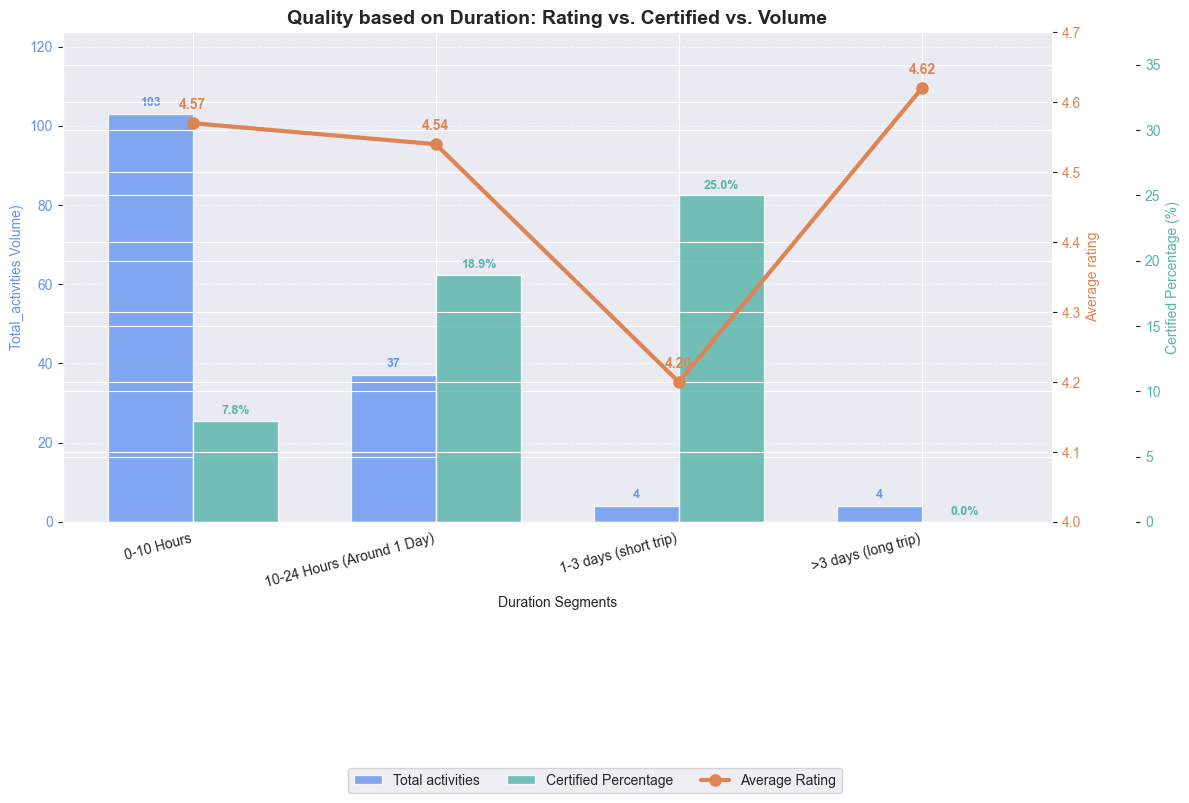

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data dari ringkasan
data = {
    'Group': ['0-10 Hours', '10-24 Hours (Around 1 Day)', '1-3 days (short trip)', '>3 days (long trip)'],
    'Avg Rating': [4.57, 4.54, 4.2, 4.62],
    'Certified Count': [8, 7, 1, 0],
    'Total Activities': [103, 37, 4, 4]
}
df = pd.DataFrame(data)

# --- Olah Ulang Data: Hitung Certified Percentage ---
# Hitung persentase tersertifikasi
df['Certified Percent'] = (df['Certified Count'] / df['Total Activities']) * 100
df['Certified Percent'] = df['Certified Percent'].fillna(0)

# Tentukan urutan kategori
order = ['0-10 Hours', '10-24 Hours (Around 1 Day)', '1-3 days (short trip)', '>3 days (long trip)']
df['Group'] = pd.Categorical(df['Group'], categories=order, ordered=True)
df = df.sort_values(by='Group')

# Inisialisasi figure dan sumbu utama (untuk Bar Chart)
fig, ax1 = plt.subplots(figsize=(12, 7))

# Tentukan parameter untuk clustered bar
bar_width = 0.35
indices = np.arange(len(df))

# --- Palet Warna ---
bar_color_total = '#6495ED'    # Biru terang (Total Activities)
bar_color_percent = '#54B4A8'  # Hijau teal (Certified Percent)
line_color = '#dd8452'         # Oranye (Avg Rating)

# --- AX1 (Sumbu Kiri): Total Activities (Bar Clustered 1) ---
ax1.bar(
    indices - bar_width/2,
    df['Total Activities'],
    bar_width,
    color=bar_color_total,
    alpha=0.8,
    label='Total activities' # Label untuk legenda
)
ax1.set_ylabel('Total_activities Volume)', color=bar_color_total)
ax1.tick_params(axis='y', labelcolor=bar_color_total)
ax1.set_ylim(0, df['Total Activities'].max() * 1.2)

# Tambahkan label Total Activities di atas bar
for i, total in enumerate(df['Total Activities']):
    ax1.text(i - bar_width/2, total + 2, f'{total}', 
             color=bar_color_total, ha='center', fontsize=9, weight='bold')

# --- AX3 (Twin dari AX1): Certified Percentage (Bar Clustered 2) ---
ax3 = ax1.twinx()
ax3.bar(
    indices + bar_width/2,
    df['Certified Percent'],
    bar_width,
    color=bar_color_percent,
    alpha=0.8,
    label='Certified Percentage' # Label untuk legenda
)
ax3.set_ylabel('Certified Percentage (%)', color=bar_color_percent)
ax3.tick_params(axis='y', labelcolor=bar_color_percent)
# Posisikan ax3 lebih jauh ke kanan agar tidak bertumpuk dengan ax2
ax3.spines['right'].set_position(('outward', 60)) 
ax3.set_ylim(0, df['Certified Percent'].max() * 1.5)

# Tambahkan label Persentase Tersertifikasi di atas bar
for i, percent in enumerate(df['Certified Percent']):
    ax3.text(i + bar_width/2, percent + 0.5, f'{percent:.1f}%', 
             color=bar_color_percent, ha='center', fontsize=9, weight='bold')

# --- AX2 (Twin dari AX1): Avg Rating (Line Plot) ---
ax2 = ax1.twinx() 
ax2.plot(
    indices,
    df['Avg Rating'],
    color=line_color,
    marker='o',
    linewidth=3,
    markersize=8,
    label='Average Rating' # Label untuk legenda
)
ax2.set_ylabel('Average rating', color=line_color)
ax2.tick_params(axis='y', labelcolor=line_color)
# Batasi skala Y untuk rating agar variasi terlihat jelas
ax2.set_ylim(4.0, 4.7) 

# Tambahkan label nilai rating di atas garis
for i, rating in enumerate(df['Avg Rating']):
    ax2.text(i, rating + 0.02, f'{rating:.2f}', color=line_color, ha='center', fontsize=10, weight='bold')

# --- Konfigurasi Sumbu X ---
ax1.set_xticks(indices)
ax1.set_xticklabels(df['Group'], rotation=15, ha='right')
ax1.set_xlabel('Duration Segments')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# --- Judul ---
plt.title('Quality based on Duration: Rating vs. Certified vs. Volume', fontsize=14, weight='bold')

# --- Legenda (Pindah ke Sudut Bawah) ---
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
all_handles = handles1 + handles3 + handles2
all_labels = labels1 + labels3 + labels2

# Menggunakan fig.legend untuk menempatkan legenda di luar plot (bottom center)
fig.legend(
    all_handles, 
    all_labels, 
    loc='lower center', 
    ncol=3, 
    bbox_to_anchor=(0.5, -0.15), 
    frameon=True
)

# Sesuaikan tata letak agar legenda tidak terpotong
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.show()


In [7]:
price_groups = {

"0-500K (Low)": filtered_df_below500k,
"500K-1M (Mid)": filtered_df_below1million,
"1m-5m (High)":filtered_df_below5million,
"> 5M (Premium)": filtered_df_above5million
}

NameError: name 'filtered_df_below500k' is not defined

In [24]:
price_summary = []
for name, df_group in price_groups.items():
    df_group['Rating'] = pd.to_numeric(df_group['Rating'], errors='coerce') 
    
    avg_rating = df_group['Rating'].mean()
    
    pct_certified = round((df_group[df_group['Certified by GYG'] == 'Yes'].shape[0] / df_group.shape[0] * 100), 1)
    
    price_summary.append({
        'Group': name,
        'Avg Rating': avg_rating,
        'Certified Percent': f"{pct_certified} %",
        'Min Price': f"Rp. {df_group['Price (IDR) Rounded'].min().astype(int)},00",
        'Max Price': f"Rp. {df_group['Price (IDR) Rounded'].max().astype(int)},00",
        
    })

price_df = pd.DataFrame(price_summary)
print("\nRingkasan Kualitas Berdasarkan Harga (Avg Rating vs. Certified Pct):")
print(price_df.to_markdown(index=False))


Ringkasan Kualitas Berdasarkan Harga (Avg Rating vs. Certified Pct):
| Group          |   Avg Rating | Certified Percent   | Min Price      | Max Price      |
|:---------------|-------------:|:--------------------|:---------------|:---------------|
| 0-500K (Low)   |      4.44815 | 3.7 %               | Rp. 240000,00  | Rp. 485000,00  |
| 500K-1M (Mid)  |      4.54375 | 8.3 %               | Rp. 507000,00  | Rp. 981000,00  |
| 1m-5m (High)   |      4.59714 | 15.5 %              | Rp. 1001000,00 | Rp. 4594000,00 |
| > 5M (Premium) |      4.65    | 0.0 %               | Rp. 7341000,00 | Rp. 7359000,00 |


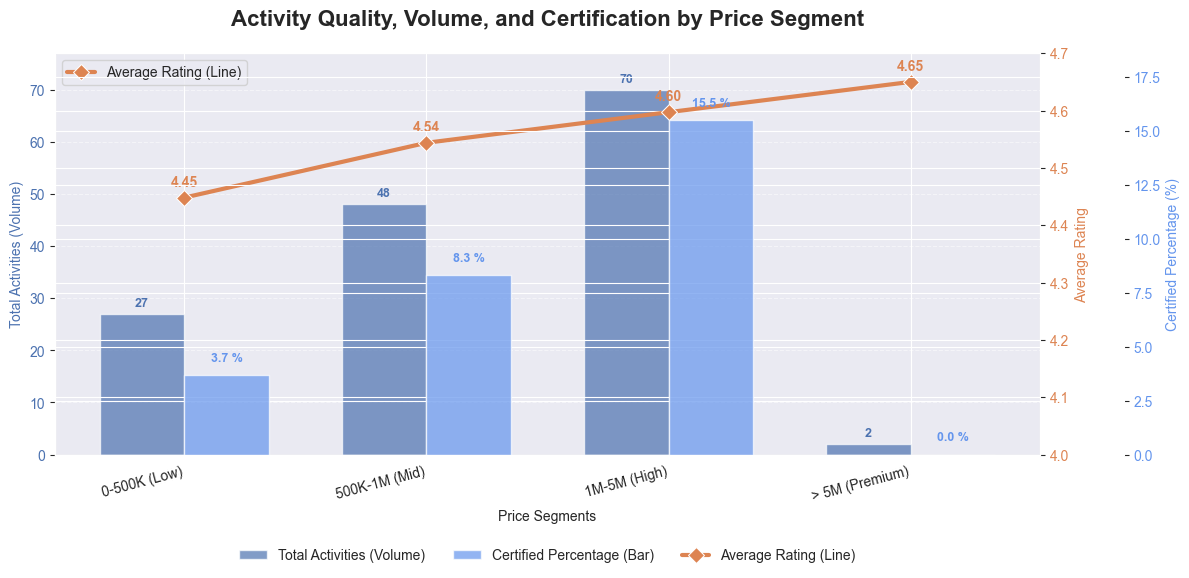

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data dari ringkasan (Termasuk data Total Activities yang baru)
data = {
    'Group': ['0-500K (Low)', '500K-1M (Mid)', '1M-5M (High)', '> 5M (Premium)'],
    'Avg Rating': [4.44815, 4.54375, 4.59714, 4.65],
    'Certified Percent': ['3.7 %', '8.3 %', '15.5 %', '0.0 %'],
    'Total Activities': [27, 48, 70, 2], # Data Volume Baru
    'Min Price': ['Rp. 240000,00', 'Rp. 507000,00', 'Rp. 1001000,00', 'Rp. 7341000,00'],
    'Max Price': ['Rp. 485000,00', 'Rp. 981000,00', 'Rp. 4594000,00', 'Rp. 7359000,00']
}
df = pd.DataFrame(data)

# Konversi 'Certified Percent' ke format numerik
df['Certified Percent Numeric'] = df['Certified Percent'].str.replace('%', '').astype(float)

# Tentukan urutan kategori secara eksplisit
order = ['0-500K (Low)', '500K-1M (Mid)', '1M-5M (High)', '> 5M (Premium)']
df['Group'] = pd.Categorical(df['Group'], categories=order, ordered=True)
df = df.sort_values(by='Group')

# --- INISIALISASI DAN OFFSET BAR UNTUK CLUSTERED CHART ---
fig, ax1 = plt.subplots(figsize=(12, 7))
bar_width = 0.35
indices = np.arange(len(df)) # Posisi dasar X (0, 1, 2, 3)

# Posisi untuk Bar 1 (Total Activities)
bar1_pos = indices - bar_width/2
# Posisi untuk Bar 2 (Certified Percent)
bar2_pos = indices + bar_width/2

# --- Sumbu Kiri (ax1): Total Activities (Bar 1) ---
color_vol = '#4c72b0' # Biru gelap
ax1.bar(
    bar1_pos,
    df['Total Activities'],
    bar_width,
    label='Total Activities (Volume)',
    color=color_vol,
    alpha=0.7
)
ax1.set_xlabel('Price Segments')
ax1.set_ylabel('Total Activities (Volume)', color=color_vol)
ax1.tick_params(axis='y', labelcolor=color_vol)
ax1.set_ylim(0, df['Total Activities'].max() * 1.1)

# Tambahkan label nilai di atas Bar 1
for i, count in enumerate(df['Total Activities']):
    ax1.text(bar1_pos[i], count + 1.5, str(count),
             color=color_vol, ha='center', fontsize=9, weight='bold')

# --- Sumbu Kanan (ax2): Average Rating (Line Chart) ---
ax2 = ax1.twinx()
color_rating = '#dd8452' # Oranye (Line)
sns.lineplot(
    x='Group',
    y='Avg Rating',
    data=df,
    ax=ax2,
    color=color_rating,
    marker='D', # Marker berbentuk diamond
    linewidth=3,
    markersize=8,
    label='Average Rating (Line)'
)
ax2.set_ylabel('Average Rating', color=color_rating)
ax2.tick_params(axis='y', labelcolor=color_rating)
ax2.set_ylim(4.0, 4.7) # Batasi skala Y untuk rating

# Tambahkan label nilai di atas garis
for i, rating in enumerate(df['Avg Rating']):
    # Menggunakan indices (0, 1, 2, 3) untuk posisi X Line
    ax2.text(indices[i], rating + 0.02, f'{rating:.2f}', color=color_rating, ha='center', fontsize=10, weight='bold')

# --- Sumbu Kanan Kedua (ax3): Certified Percentage (Bar 2) ---
# Kita perlu menggeser sumbu Y kedua ini agar tidak menimpa ax2 (Rating)
ax3 = ax1.twinx()
color_cert = '#6495ED' # Biru muda
ax3.spines['right'].set_position(('outward', 60)) # Geser sumbu ke kanan sejauh 60 poin

ax3.bar(
    bar2_pos,
    df['Certified Percent Numeric'],
    bar_width,
    label='Certified Percentage (Bar)',
    color=color_cert,
    alpha=0.7
)
ax3.set_ylabel('Certified Percentage (%)', color=color_cert)
ax3.tick_params(axis='y', labelcolor=color_cert)
ax3.set_ylim(0, df['Certified Percent Numeric'].max() * 1.2)

# Tambahkan label nilai di atas Bar 2
for i, pct in enumerate(df['Certified Percent Numeric']):
    ax3.text(bar2_pos[i], pct + 0.5, f"{df['Certified Percent'].iloc[i]}",
             color=color_cert, ha='center', va='bottom', fontsize=9, weight='bold')

# --- PENYESUAIAN SUMBU X ---
ax1.set_xticks(indices)
ax1.set_xticklabels(df['Group'], rotation=15, ha='right')

# --- JUDUL & LEGEND ---
plt.title('Activity Quality, Volume, and Certification by Price Segment', fontsize=16, weight='bold', pad=20)

# Kumpulkan semua handle dan label dari ketiga sumbu
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Gabungkan dan tampilkan legenda di bawah grafik
ax1.legend(
    handles1 + handles3 + handles2,
    labels1 + labels3 + labels2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.3), # Pindahkan legenda ke bawah grafik
    ncol=3,
    frameon=False,
    fontsize=10
)

# Layout dan tampilkan plot
fig.tight_layout(rect=[0, 0.1, 1, 1]) # Sesuaikan layout agar legenda di bawah tidak terpotong
ax1.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [25]:

null_values = ['N/A', '', 'None']

df = df.replace(null_values, pd.NA)


df_clean = df.dropna().copy()


total_rows_initial = len(df)
total_rows_cleaned = len(df_clean)

print(f"Jumlah baris awal: {total_rows_initial}")
print(f"Jumlah baris setelah dibersihkan (dihapus): {total_rows_cleaned}")
print(f"Jumlah baris yang dihapus: {total_rows_initial - total_rows_cleaned}")

Jumlah baris awal: 148
Jumlah baris setelah dibersihkan (dihapus): 147
Jumlah baris yang dihapus: 1


In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 147
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                147 non-null    object 
 1   Duration-Trip        147 non-null    object 
 2   Rating               147 non-null    object 
 3   Price (IDR)          147 non-null    int32  
 4   Certified by GYG     147 non-null    object 
 5   Duration (Days)      147 non-null    Float64
 6   Duration (Hours)     147 non-null    Float64
 7   Remaining Hours      147 non-null    Float64
 8   Duration             147 non-null    object 
 9   Price (IDR) Rounded  147 non-null    Int64  
dtypes: Float64(3), Int64(1), int32(1), object(5)
memory usage: 12.6+ KB


C:\Users\M S I\AppData\Local\Temp\ipykernel_20944\3191663438.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


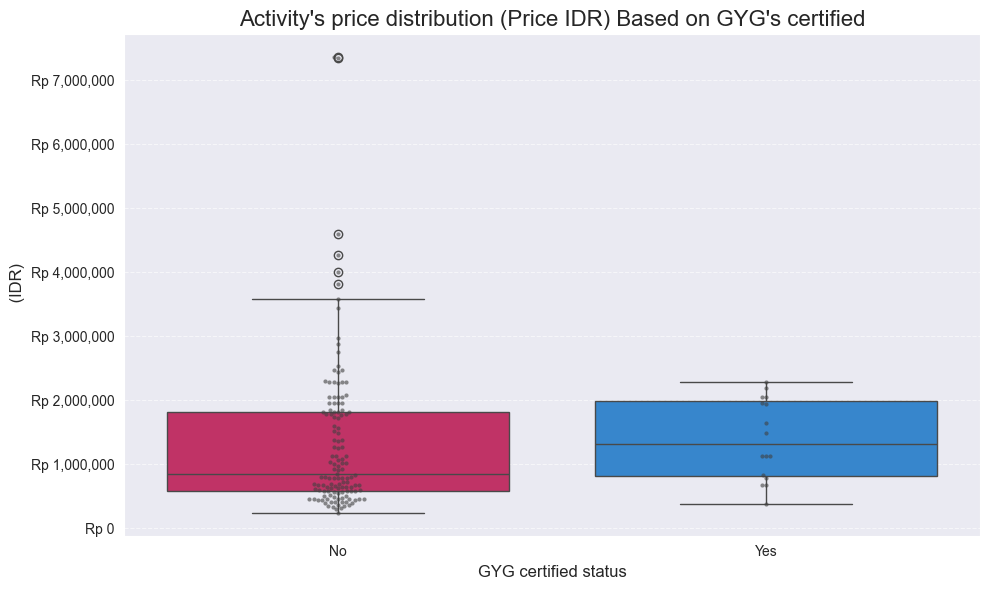

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_clean = pd.read_csv("london_activities_GYG.csv")

if 'Price (IDR) Rounded' in df_clean.columns:
    df_clean['Price (IDR) Rounded'] = pd.to_numeric(df_clean['Price (IDR) Rounded'], errors='coerce')
    if 'Rating' in df_clean.columns:
        df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')

df_clean.dropna(subset=['Price (IDR) Rounded', 'Certified by GYG'], inplace=True)


palette_colors = {'Yes': '#1E88E5', 'No': '#D81B60'} # Biru untuk Yes, Merah untuk No

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Certified by GYG', 
    y='Price (IDR) Rounded', 
    data=df_clean, 
    palette=palette_colors
) 

sns.swarmplot(
    x='Certified by GYG', 
    y='Price (IDR) Rounded', 
    data=df_clean, 
    color='0.25', # Warna abu-abu
    size=3,       # Ukuran titik
    alpha=0.6     # Transparansi
)

plt.title('Activity\'s price distribution (Price IDR) Based on GYG\'s certified', fontsize=16)
plt.xlabel('GYG certified status', fontsize=12)
plt.ylabel(' (IDR)', fontsize=12)

from matplotlib.ticker import FuncFormatter
def currency_formatter(x, pos):
    'The two args are the value and tick position'
    return f'Rp {int(x):,}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))


# 5. --- Tampilkan Plot ---
plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.tight_layout()
plt.show()

In [28]:
df_clean['Price per Hour'] = np.where(
    df_clean['Duration (Hours)'] > 0, 
    df_clean['Price (IDR)'] / df_clean['Duration (Hours)'], 
    0
)
duration_bins = [0, 10, 24, df_clean['Duration (Hours)'].max() + 1]
duration_labels = ["0-10 Hours", "Full Day", ">Long Trip"]
df_clean['Duration Segment'] = pd.cut(
    df_clean['Duration (Hours)'],
    bins=duration_bins,
    labels=duration_labels,
    right=False,  # Rentang [batas bawah, batas atas)
    include_lowest=True
)
cost_efficiency_summary = df_clean.groupby('Duration Segment', observed=True)['Price per Hour'].mean().reset_index()
cost_efficiency_summary = cost_efficiency_summary.rename(columns={'Price per Hour': 'Avg Price per Hour'})
cost_efficiency_summary['Avg Price per Hour'] = cost_efficiency_summary['Avg Price per Hour'].round(0) # Pembulatan

print("Ringkasan Efisiensi Biaya (Rata-rata Harga per Jam):")
print(cost_efficiency_summary.to_markdown(index=False))

Ringkasan Efisiensi Biaya (Rata-rata Harga per Jam):
| Duration Segment   |   Avg Price per Hour |
|:-------------------|---------------------:|
| 0-10 Hours         |               570608 |
| Full Day           |               228448 |
| >Long Trip         |                31885 |


In [17]:


raw_df = pd.read_csv("london_activities_GYG.csv")

print("Data Asli:")
print(raw_df)
print("-" * 30)

# --- LOGIKA PEMBULATAN KE RIBUAN TERDEKAT ---

# PERBAIKAN: Memastikan kolom 'Price per Hour' adalah numerik (float)
# Ini mengatasi 'TypeError: string indices must be integers' yang muncul
# saat mencoba melakukan pembagian pada data string.
raw_df['Price per Hour'] = pd.to_numeric(raw_df['Price per Hour'], errors='coerce')


# 1. Bagi nilai dengan 1000.
# 2. Gunakan np.floor() untuk membulatkan ke bawah ke bilangan bulat terdekat (misal: 328.63 -> 328).
# 3. Kalikan hasilnya kembali dengan 1000.
# 4. Konversi ke integer untuk menghilangkan koma desimal secara permanen.

raw_df['Price per Hour Rounded'] = (
    np.floor(raw_df['Price per Hour'])
).astype(int)

raw_df = raw_df.drop('Price per Hour', axis=1)

# --- 4. VERIFIKASI HASIL ---
print("DataFrame Setelah Penghapusan dan Penggantian Kolom:")
print("Jumlah Kolom Akhir:", len(raw_df.columns))
print("\nContoh 5 Baris Teratas:")
print(raw_df.head())

raw_df.to_csv('London_activities_GYG_newest.csv', index=False)


Data Asli:
                                                 Title  Rating  \
0    London: Warner Bros. Studio Harry Potter Tour ...     4.7   
1    From London: Harry Potter Warner Bros Studio Tour     4.7   
2    London: The Wizarding World of Westminster Wal...     4.3   
3    London: Tootbus Hop-on Hop-off (Optional River...     3.9   
4    London: Warner Bros. Studio Harry Potter Tour ...     4.6   
..                                                 ...     ...   
142  London: London in WW2 and Churchill War Rooms ...     4.9   
143          London: Moorgate Hidden Tube Station Tour     4.4   
144    Harry Potter Walking Tour Including New College     4.6   
145  Oxford: University and City Walking Tour with ...     4.7   
146  Oxford: University Walking Tour with Christ Ch...     4.6   

    Certified by GYG  Duration (Days)  Duration (Hours) Duration  \
0                 No              0.0              7.44    0d 7h   
1                 No              0.0              6.96    0

C:\Users\M S I\AppData\Local\Temp\ipykernel_3452\1300586991.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


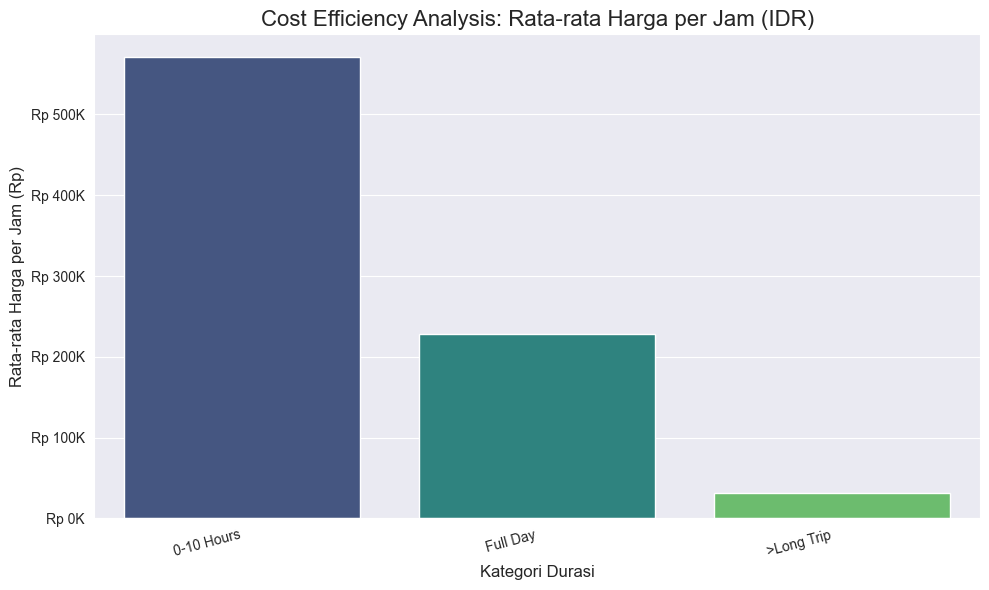

In [29]:
# --- Visualisasi Cost Efficiency ---
plt.figure(figsize=(10, 6))

cost_efficiency_sorted = cost_efficiency_summary.sort_values(by='Avg Price per Hour', ascending=True)

sns.barplot(
    x='Duration Segment', 
    y='Avg Price per Hour', 
    data=cost_efficiency_sorted, 
    palette='viridis' # Skema warna cerah
)
plt.title('Cost Efficiency Analysis: Rata-rata Harga per Jam (IDR)', fontsize=16)
plt.xlabel('Kategori Durasi', fontsize=12)
plt.ylabel('Rata-rata Harga per Jam (Rp)', fontsize=12)

plt.xticks(rotation=15, ha='right')

from matplotlib.ticker import FuncFormatter
def currency_formatter(x, pos):
    return f'Rp {int(x/1000)}K'
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.tight_layout()
plt.show()

In [30]:
# 1. Definisikan batas BINS (potongan)
bins = [
    0,            
    500000,       
    1000000,      
    5000000,      
    df['Price (IDR) Rounded'].max() + 1 # Batas atas
]

# 2. Definisikan LABEL untuk setiap BINS
labels = [
    "0 - 500K (Low)",
    "500K - 1M (Mid)",
    "1M - 5M (High)",
    "> 5M (Premium)"
]

# 3. Buat Kolom Segmentasi
df_clean['Price Segment'] = pd.cut(
    df['Price (IDR) Rounded'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

In [31]:
# 1. Definisikan batas BINS (potongan)
bins = [
    0,            
    10,       
    24,      
    72,      
    df['Duration (Hours)'].max() + 1 # Batas atas
]

# 2. Definisikan LABEL untuk setiap BINS
labels = [
    "0-10 Hours",
    "10-24 Hours (Around 1 Day)",
    "1-3 days (short trip)",
    ">3 days (long trip)"
]

# 3. Buat Kolom Segmentasi
df_clean['Duration Segment'] = pd.cut(
    df['Duration (Hours)'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

In [32]:
print(df_clean[['Price (IDR) Rounded','Price Segment', 'Duration Segment']].head(20).to_markdown(index=False))

|   Price (IDR) Rounded | Price Segment   | Duration Segment           |
|----------------------:|:----------------|:---------------------------|
|               2445000 | 1M - 5M (High)  | 0-10 Hours                 |
|               2262000 | 1M - 5M (High)  | 0-10 Hours                 |
|                461000 | 0 - 500K (Low)  | 0-10 Hours                 |
|                609000 | 500K - 1M (Mid) | 1-3 days (short trip)      |
|               2285000 | 1M - 5M (High)  | 0-10 Hours                 |
|                669000 | 500K - 1M (Mid) | 0-10 Hours                 |
|                510000 | 500K - 1M (Mid) | 0-10 Hours                 |
|                439000 | 0 - 500K (Low)  | 0-10 Hours                 |
|                381000 | 0 - 500K (Low)  | 0-10 Hours                 |
|               1644000 | 1M - 5M (High)  | 10-24 Hours (Around 1 Day) |
|                391000 | 0 - 500K (Low)  | 0-10 Hours                 |
|                826000 | 500K - 1M (Mid) | 10-24 H

In [33]:
import pandas as pd
import numpy as np

# ASUMSI: df_clean dan kolom 'Price Segment' sudah ada dan bersih

# Pastikan Rating sudah numerik
df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce') 

# Groupby berdasarkan Price Segment
price_segment_analysis = df_clean.groupby('Price Segment', observed=True).agg(
    # Metrik 1: Rata-rata Rating
    Avg_Rating=('Rating', 'mean'),
    
   
    N_activity=('Title', 'count'),
    
    # Metrik 3: Persentase Certified
    Certified_Count=('Certified by GYG', lambda x: (x == 'Yes').sum()),
    
    # Metrik 4: Rata-rata Harga (untuk referensi)
    Avg_Price=('Price (IDR) Rounded', 'mean')
).reset_index()

# Hitung Persentase Certified
price_segment_analysis['Pct_Certified'] = round(
    (price_segment_analysis['Certified_Count'] / price_segment_analysis['N_activity']) * 100,
    0
)
price_segment_analysis['Pct_Certified'] = price_segment_analysis['Pct_Certified'].astype(int).astype(str) + ' %'

# Pembulatan Avg Rating
price_segment_analysis['Avg_Rating'] = round(price_segment_analysis['Avg_Rating'], 2)
price_segment_analysis['Avg_Price'] = price_segment_analysis['Avg_Price'].astype(int)

# Urutkan berdasarkan segmen (memastikan urutan Low ke Premium)
segment_order = ["0 - 500K (Low)", "500K - 1M (Mid)", "1M - 5M (High)", "> 5M (Premium)"]
price_segment_analysis['Price Segment'] = pd.Categorical(
    price_segment_analysis['Price Segment'], 
    categories=segment_order, 
    ordered=True
)
price_segment_analysis = price_segment_analysis.drop(columns=['N_activity', 'Certified_Count'])
price_segment_analysis = price_segment_analysis.sort_values('Price Segment')

print("\n--- Ringkasan Kualitas dan Risiko Berdasarkan Segmen Harga ---")
print(price_segment_analysis.to_markdown(index=False))


--- Ringkasan Kualitas dan Risiko Berdasarkan Segmen Harga ---
| Price Segment   |   Avg_Rating |   Avg_Price | Pct_Certified   |
|:----------------|-------------:|------------:|:----------------|
| 0 - 500K (Low)  |         4.45 |      405000 | 4 %             |
| 500K - 1M (Mid) |         4.54 |      694416 | 8 %             |
| 1M - 5M (High)  |         4.6  |     1977028 | 16 %            |
| > 5M (Premium)  |         4.65 |     7350000 | 0 %             |


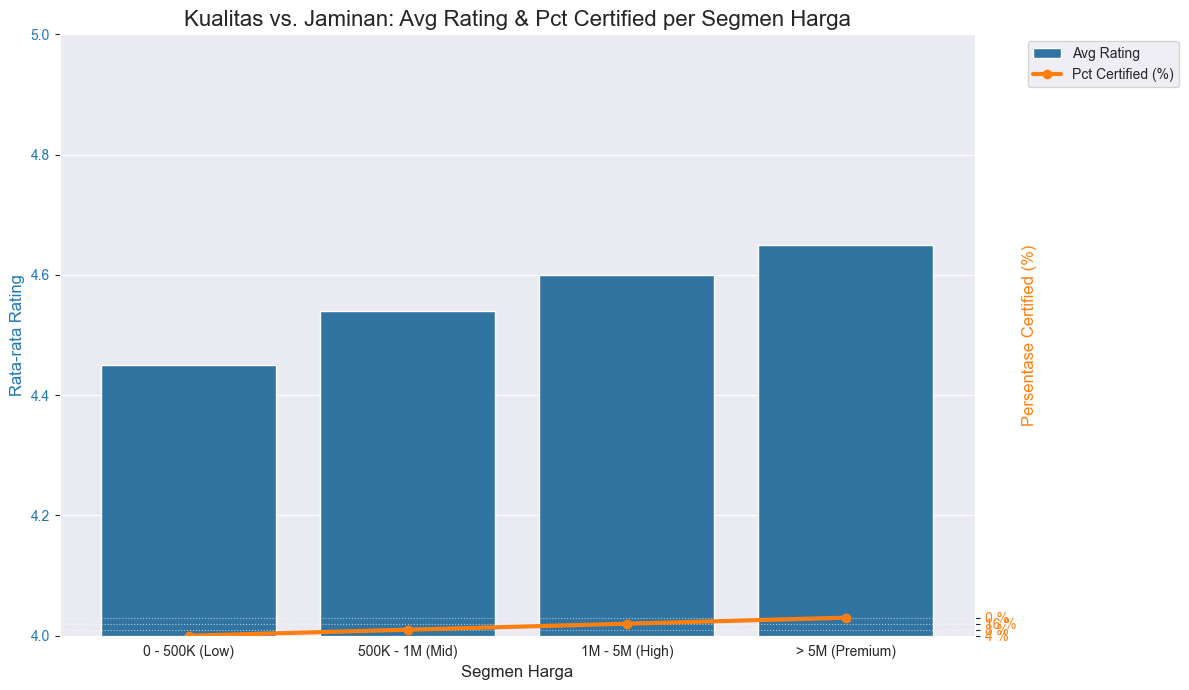

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 7)) # Figure dan Sumbu Utama (ax1)

# Tentukan urutan segmen harga (agar Bar muncul secara berurutan)
segment_order = ["0 - 500K (Low)", "500K - 1M (Mid)", "1M - 5M (High)", "> 5M (Premium)"]

# --- Sumbu Y Utama (Kolom/Bar untuk Rata-rata Rating) ---
color_bars = '#1f77b4' # Biru
sns.barplot(
    x='Price Segment', 
    y='Avg_Rating', 
    data=price_segment_analysis, 
    order=segment_order,
    color=color_bars,
    ax=ax1,
    label='Avg Rating'
)
ax1.set_ylabel('Rata-rata Rating', color=color_bars, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_bars)
ax1.set_ylim(4.0, 5.0) # Fokuskan sumbu Rating pada skala 4.0 - 5.0

# --- Sumbu Y Sekunder (Garis/Line untuk Persentase Certified) ---
ax2 = ax1.twinx() # Membuat sumbu Y kedua yang berbagi sumbu X
color_line = '#ff7f0e' # Oranye
ax2.plot(
    price_segment_analysis['Price Segment'], 
    price_segment_analysis['Pct_Certified'], 
    color=color_line, 
    marker='o', # Marker lingkaran pada setiap titik
    linewidth=3,
    label='Pct Certified (%)'
)
ax2.set_ylabel('Persentase Certified (%)', color=color_line, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.set_ylim(0, 100) # Sumbu Persentase (0% - 100%)

# --- Labeling dan Formatting ---

plt.title('Kualitas vs. Jaminan: Avg Rating & Pct Certified per Segmen Harga', fontsize=16)
ax1.set_xlabel('Segmen Harga', fontsize=12)

# Menggabungkan Legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.grid(True, linestyle=':', alpha=0.6, axis='y')
fig.tight_layout()
plt.show()

In [35]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 147
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Title                147 non-null    object  
 1   Duration-Trip        147 non-null    object  
 2   Rating               147 non-null    float64 
 3   Price (IDR)          147 non-null    int32   
 4   Certified by GYG     147 non-null    object  
 5   Duration (Days)      147 non-null    Float64 
 6   Duration (Hours)     147 non-null    Float64 
 7   Remaining Hours      147 non-null    Float64 
 8   Duration             147 non-null    object  
 9   Price (IDR) Rounded  147 non-null    Int64   
 10  Price per Hour       147 non-null    float64 
 11  Duration Segment     147 non-null    category
 12  Price Segment        147 non-null    category
dtypes: Float64(3), Int64(1), category(2), float64(2), int32(1), object(4)
memory usage: 14.5+ KB


In [36]:
new_columns_order = [
    'Title',
    'Rating',
    'Certified by GYG',
    'Duration (Days)',
    'Duration (Hours)',
    'Duration',        # Posisi baru
    'Remaining Hours', # Posisi baru
    'Price (IDR) Rounded',
    'Price per Hour',
    'Duration Segment',
    'Price Segment'
]

In [37]:
df_clean = df_clean[new_columns_order]

In [38]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 147
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Title                147 non-null    object  
 1   Rating               147 non-null    float64 
 2   Certified by GYG     147 non-null    object  
 3   Duration (Days)      147 non-null    Float64 
 4   Duration (Hours)     147 non-null    Float64 
 5   Duration             147 non-null    object  
 6   Remaining Hours      147 non-null    Float64 
 7   Price (IDR) Rounded  147 non-null    Int64   
 8   Price per Hour       147 non-null    float64 
 9   Duration Segment     147 non-null    category
 10  Price Segment        147 non-null    category
dtypes: Float64(3), Int64(1), category(2), float64(2), object(3)
memory usage: 12.7+ KB


In [39]:
df_clean.to_csv('London_activities_GYG.csv', index=False)